
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

In [20]:
# Importação das bibliotecas
import pandas as pd
import numpy as np

from keras.models import Sequential
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score

from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt

In [3]:
DROPOUT = 0.05
LEARNING_RATE = 5e-4
EPOCHS = 5
FOLDS = 5

In [4]:
# Carregando 50-dimensional GloVe embeddings
glove_file = '../embeddings/glove.6B.50d.txt'
glove_embeddings = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding = np.array(values[1:], dtype='float32')
        
        # Tratando a substituição da vírgula por ponto no vetor de embedding
        if ',' in values[1]:
            embedding = [float(val.replace(',', '.')) for val in values[1:]]
        
        glove_embeddings[word] = embedding

In [5]:
embedding_dim = len(next(iter(glove_embeddings.values())))

print('Achados %s vetores de palavras' % len(glove_embeddings))
print(f'Vetores de {embedding_dim} dimensões')

Achados 400000 vetores de palavras
Vetores de 50 dimensões


In [6]:
# Carregando dataset pre-processado
df = pd.read_csv('../datasets/b2w_preprocessed_balanced_cleared_all_instances.csv')

In [7]:
df.shape

(116058, 2)

In [8]:
reviews_batch_01, reviews_batch_02, labels_batch_01, labels_batch_02 = train_test_split(df['review_text'], df['rating'], test_size=0.5, random_state=42)

In [9]:
print(reviews_batch_01.shape[0])
print(reviews_batch_02.shape[0])

58029
58029


In [10]:
print(labels_batch_01.value_counts())

1    40089
0    17940
Name: rating, dtype: int64


In [11]:
documents = reviews_batch_01
labels = np.array(labels_batch_01)

In [12]:
# Tokenização e embedding dos documentos
max_sequence_length = 20  # Número máximo de palavras por documento
embedded_documents = []
for doc in documents:
    words = str(doc).lower().split()
    embedded_doc = [glove_embeddings.get(word, np.zeros(embedding_dim)) for word in words]
    if len(embedded_doc) < max_sequence_length:
        embedded_doc.extend([np.zeros(embedding_dim)] * (max_sequence_length - len(embedded_doc)))
    else:
        embedded_doc = embedded_doc[:max_sequence_length]
    embedded_documents.append(embedded_doc)

embedded_documents = np.array(embedded_documents)

In [13]:
# Arquitetura de rede neural MLP
model = Sequential()
model.add(Dense(24, activation="relu", input_shape=(max_sequence_length, embedding_dim)))
model.add(Flatten())
model.add(Dropout(DROPOUT))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20, 24)            1224      
                                                                 
 flatten (Flatten)           (None, 480)               0         
                                                                 
 dropout (Dropout)           (None, 480)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 481       
                                                                 
Total params: 1,705
Trainable params: 1,705
Non-trainable params: 0
_________________________________________________________________


In [14]:
LOSS = 'binary_crossentropy'
OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
METRICS = ['accuracy']
BATCH_SIZE = 32
CHECKPOINT = ModelCheckpoint(filepath='../weights/glove_mlp_weights.hdf5')
EARLY_STOP = EarlyStopping('val_loss', patience=5)
CALLBACKS = [CHECKPOINT, EARLY_STOP]
VERBOSE=1

In [15]:
# k-fold cross-validation
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

In [16]:
# Compilando o modelo
model.compile(
    loss=LOSS,
    optimizer=OPTIMIZER, 
    metrics=METRICS
)

In [17]:
train_loss_history = []
train_accuracy_history = []

fold_accuracies = []
fold_f1_scores = []
for fold, (train_idx, test_idx) in enumerate(skf.split(embedded_documents, labels), start=1):
    print(f'fold = {fold} de {FOLDS}')
    X_train, X_test = embedded_documents[train_idx], embedded_documents[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]

    model_history = model.fit(
        X_train, 
        y_train, 
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        verbose=VERBOSE,
        validation_data=(X_test, y_test),
        callbacks=CALLBACKS
    )
    
    # loss e acuracia do treino
    train_loss_history.append(model_history.history['loss'])
    train_accuracy_history.append(model_history.history['accuracy'])
    
    # Acuracia de cada fold
    _, fold_accuracy = model.evaluate(X_test, y_test)
    fold_accuracies.append(fold_accuracy)
    
    # Predições das labels
    y_pred = (model.predict(X_test) > 0.5).astype(int) 
    
    # Calculando F1 score
    fold_f1 = f1_score(y_test, y_pred)  
    fold_f1_scores.append(fold_f1)
    
    print(f"Fold {fold}: Accuracy = {fold_accuracy:.2f}, F1 Score = {fold_f1:.2f}")

avg_train_loss = np.mean(train_loss_history)
print(f"Average Train Loss: {avg_train_loss:.2f}")

avg_train_accuracy = np.mean(train_accuracy_history)
print(f"Average Train Accuracy: {avg_train_accuracy:.2f}")

# Calculando acuracia
avg_accuracy = np.mean(fold_accuracies)
print(f"Average Accuracy: {avg_accuracy:.2f}")

# Calculando f1 score
avg_f1_score = np.mean(fold_f1_scores)
print(f"Average F1 Score: {avg_f1_score:.2f}")

fold = 1 de 5
Epoch 1/5
1451/1451 [==============================] - 23s 15ms/step - loss: 0.4786 - accuracy: 0.7626 - val_loss: 0.3970 - val_accuracy: 0.8192
Epoch 2/5
1451/1451 [==============================] - 36s 25ms/step - loss: 0.3878 - accuracy: 0.8200 - val_loss: 0.3666 - val_accuracy: 0.8330
Epoch 3/5
1451/1451 [==============================] - 26s 18ms/step - loss: 0.3675 - accuracy: 0.8326 - val_loss: 0.3518 - val_accuracy: 0.8422
Epoch 4/5
1451/1451 [==============================] - 22s 15ms/step - loss: 0.3537 - accuracy: 0.8409 - val_loss: 0.3411 - val_accuracy: 0.8466
Epoch 5/5
363/363 [==============================] - 5s 14ms/step
Fold 1: Accuracy = 0.85, F1 Score = 0.90
fold = 2 de 5
Epoch 1/5
1451/1451 [==============================] - 21s 14ms/step - loss: 0.3351 - accuracy: 0.8523 - val_loss: 0.3381 - val_accuracy: 0.8460
Epoch 2/5
1451/1451 [==============================] - 24s 16ms/step - loss: 0.3281 - accuracy: 0.8547 - val_loss: 0.3399 - val_accuracy: 0.

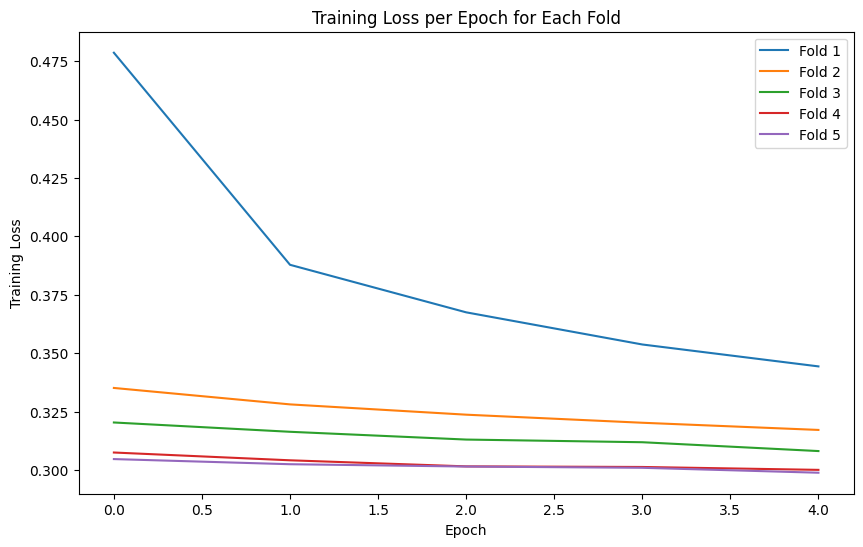

In [21]:
plt.figure(figsize=(10, 6))
for fold_num, fold_loss in enumerate(train_loss_history):
    plt.plot(fold_loss, label=f'Fold {fold_num+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch for Each Fold')
plt.legend()
plt.show()

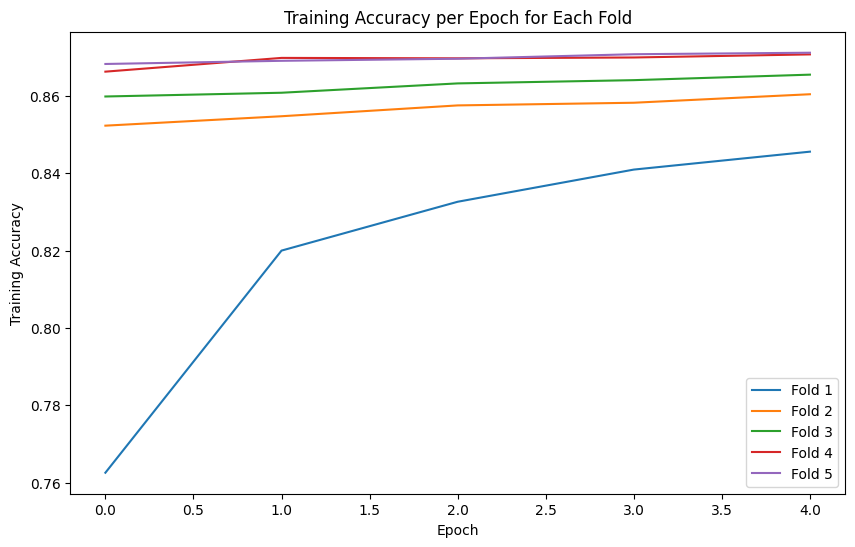

In [22]:
plt.figure(figsize=(10, 6))
for fold_num, fold_accuracy in enumerate(train_accuracy_history):
    plt.plot(fold_accuracy, label=f'Fold {fold_num+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy per Epoch for Each Fold')
plt.legend()
plt.show()

In [24]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

363/363 [==============================] - 2s 4ms/step - loss: 0.2899 - accuracy: 0.8737


In [25]:
def load_weights_from_hdf5(model, weight_path):
    model.load_weights(weight_path)
    return model

In [26]:
glove_mlp_weights_path = '../weights/glove_mlp_weights.hdf5'
model = load_weights_from_hdf5(model, glove_mlp_weights_path)

fold = 1 de 5
Epoch 1/5
1451/1451 [==============================] - 21s 14ms/step - loss: 0.3014 - accuracy: 0.8712 - val_loss: 0.2850 - val_accuracy: 0.8740
Epoch 2/5
1451/1451 [==============================] - 27s 18ms/step - loss: 0.3002 - accuracy: 0.8700 - val_loss: 0.2886 - val_accuracy: 0.8780
Epoch 3/5
1451/1451 [==============================] - 24s 17ms/step - loss: 0.2979 - accuracy: 0.8722 - val_loss: 0.2877 - val_accuracy: 0.8731
Epoch 4/5
1451/1451 [==============================] - 28s 19ms/step - loss: 0.2970 - accuracy: 0.8723 - val_loss: 0.2840 - val_accuracy: 0.8799
Epoch 5/5
363/363 [==============================] - 4s 11ms/step
Fold 1: Accuracy = 0.88, F1 Score = 0.91
fold = 2 de 5
Epoch 1/5
1451/1451 [==============================] - 21s 14ms/step - loss: 0.2937 - accuracy: 0.8738 - val_loss: 0.2943 - val_accuracy: 0.8710
Epoch 2/5
1451/1451 [==============================] - 27s 19ms/step - loss: 0.2910 - accuracy: 0.8747 - val_loss: 0.2938 - val_accuracy: 0.

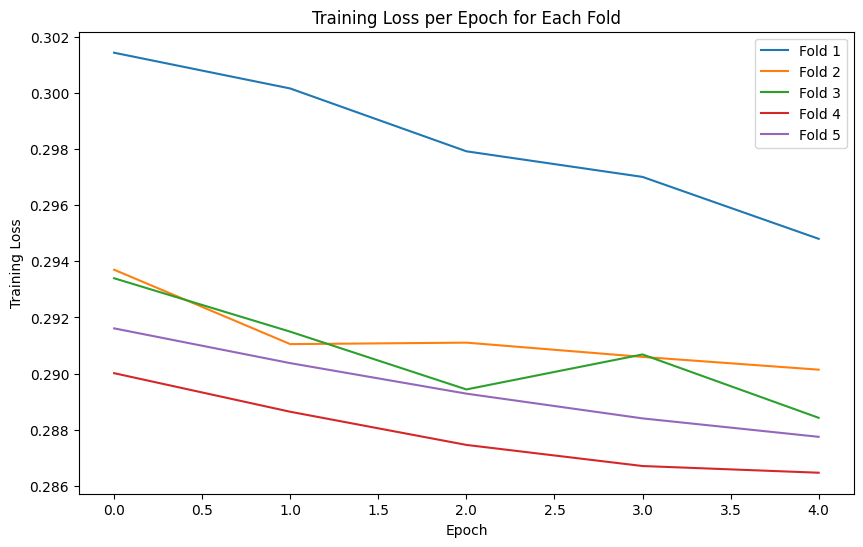

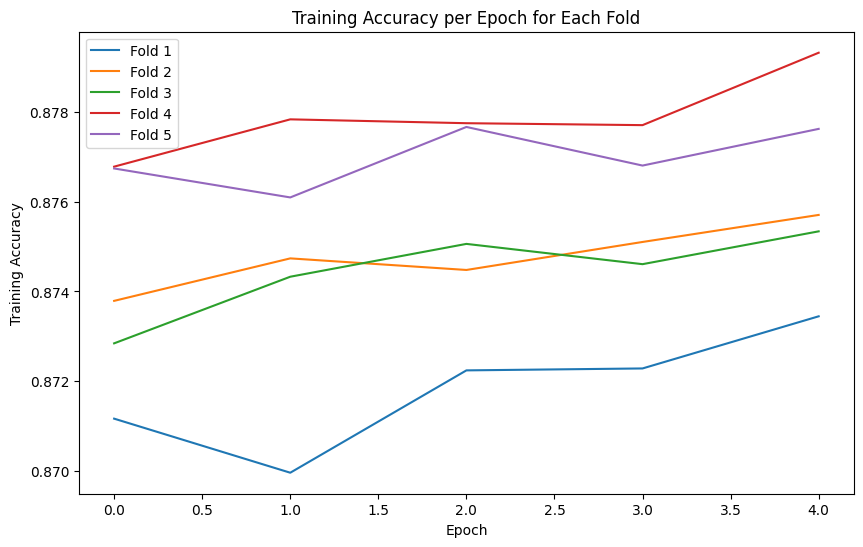

In [27]:
train_loss_history = []
train_accuracy_history = []

fold_accuracies = []
fold_f1_scores = []
for fold, (train_idx, test_idx) in enumerate(skf.split(embedded_documents, labels), start=1):
    print(f'fold = {fold} de {FOLDS}')
    X_train, X_test = embedded_documents[train_idx], embedded_documents[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]

    model_history = model.fit(
        X_train, 
        y_train, 
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        verbose=VERBOSE,
        validation_data=(X_test, y_test),
        callbacks=CALLBACKS
    )
    
    # loss e acuracia do treino
    train_loss_history.append(model_history.history['loss'])
    train_accuracy_history.append(model_history.history['accuracy'])
    
    # Acuracia de cada fold
    _, fold_accuracy = model.evaluate(X_test, y_test)
    fold_accuracies.append(fold_accuracy)
    
    # Predições das labels
    y_pred = (model.predict(X_test) > 0.5).astype(int) 
    
    # Calculando F1 score
    fold_f1 = f1_score(y_test, y_pred)  
    fold_f1_scores.append(fold_f1)
    
    print(f"Fold {fold}: Accuracy = {fold_accuracy:.2f}, F1 Score = {fold_f1:.2f}")

avg_train_loss = np.mean(train_loss_history)
print(f"Average Train Loss: {avg_train_loss:.2f}")

avg_train_accuracy = np.mean(train_accuracy_history)
print(f"Average Train Accuracy: {avg_train_accuracy:.2f}")

# Calculando acuracia
avg_accuracy = np.mean(fold_accuracies)
print(f"Average Accuracy: {avg_accuracy:.2f}")

# Calculando f1 score
avg_f1_score = np.mean(fold_f1_scores)
print(f"Average F1 Score: {avg_f1_score:.2f}")

plt.figure(figsize=(10, 6))
for fold_num, fold_loss in enumerate(train_loss_history):
    plt.plot(fold_loss, label=f'Fold {fold_num+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch for Each Fold')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for fold_num, fold_accuracy in enumerate(train_accuracy_history):
    plt.plot(fold_accuracy, label=f'Fold {fold_num+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy per Epoch for Each Fold')
plt.legend()
plt.show()